In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)


In [3]:
df = pd.read_csv("F:\\MultiDimensionalAD\\data\\long_run_labelled.csv")

# Sort by time just in case
if "Seconds" in df.columns:
    df = df.sort_values("Seconds")

# Drop non-numeric columns automatically
non_numeric = df.select_dtypes(exclude=[np.number]).columns
df_num = df.drop(columns=non_numeric)

print("Using numeric columns:")
print(df_num.columns.tolist())


Using numeric columns:
['Seconds', '10-PI-1110', '10-TI-1103', '10-MOV1118', '20-PT-1312', '20-TE', '20-MOV-1301', '20-FIC-1301', '20-MOV-1304', 'S1-PT-1001B', 'S1-PT-1001A', 'S1-TT-1001B', 'S1-TT-1001A', 'S1-MOV-1001', 'S2-PT-1002B', 'S2-PT-1002A', 'S2-TT-1002B', 'S2-TT-1002A', 'S2-MOV-1002', 'C4-PI-1016', 'CP4', 'C5-PI-1016', 'CP5', '11-PT-1202', '11-TT-1201A', '11-MV1201-STS', 'C7-PI-1016', 'CP7', 'C8-PI-1016', 'CP8', '20-MOV-1303', '10-MOV1117', '10-MOV1121', '10-MOV1104', '10-MOV1101', '10-MOV1102', 'VISHAKA_NG-HSD', '10-MOV1103', '10-MOV1134', '10-MOV-1140', 'MOV_3018', 'MOV_3018.1', '11-PT-1203', 'TT-1201B', 'MOV_1206', 'MOV_3019', 'MOV_1203']


In [6]:

X_raw = df_num.values

scaler_raw = StandardScaler()
X_raw_scaled = scaler_raw.fit_transform(X_raw)




In [7]:
X = df_num.copy()

# 1. Temporal deltas (captures dynamics, not magnitude)
delta = X.diff().fillna(0)
delta.columns = [c + "_d" for c in delta.columns]

# 2. Rolling residuals (captures deviations from local equilibrium)
rolling_mean = X.rolling(window=10, min_periods=1).mean()
residual = X - rolling_mean
residual.columns = [c + "_res" for c in residual.columns]

# 3. Pressure consistency examples (auto-detected)
pressure_cols = [c for c in X.columns if "P" in c or "PT" in c or "PI" in c]

pressure_spread = pd.DataFrame()
if len(pressure_cols) > 1:
    pressure_spread["pressure_std"] = X[pressure_cols].std(axis=1)
    pressure_spread["pressure_range"] = (
        X[pressure_cols].max(axis=1) - X[pressure_cols].min(axis=1)
    )

# Combine physics-aware features
X_phys = pd.concat([delta, residual, pressure_spread], axis=1)

scaler_phys = StandardScaler()
X_phys_scaled = scaler_phys.fit_transform(X_phys)


In [8]:
iso_raw = IsolationForest(contamination=0.01, random_state=42)
iso_phys = IsolationForest(contamination=0.01, random_state=42)

raw_scores_if = -iso_raw.fit(X_raw_scaled).score_samples(X_raw_scaled)
phys_scores_if = -iso_phys.fit(X_phys_scaled).score_samples(X_phys_scaled)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [21]:
class AutoEncoder(nn.Module):
    def __init__(self, dim, bottleneck=8):
        super().__init__()

        hidden1 = max(dim // 2, bottleneck * 2)

        self.encoder = nn.Sequential(
            nn.Linear(dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, bottleneck),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [23]:
def train_autoencoder(X, epochs=30, batch_size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset stays on CPU
    X_tensor = torch.tensor(X, dtype=torch.float32)
    loader = DataLoader(
        TensorDataset(X_tensor),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=(device.type == "cuda")
    )

    model = AutoEncoder(X.shape[1], bottleneck=8).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for (batch,) in loader:
            batch = batch.to(device, non_blocking=True)

            opt.zero_grad()
            recon = model(batch)
            loss = loss_fn(recon, batch)
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        X_gpu = X_tensor.to(device)
        recon = model(X_gpu)
        recon_error = ((recon - X_gpu) ** 2).mean(dim=1)

    return recon_error.detach().cpu().numpy()


In [24]:
raw_ae_error = train_autoencoder(X_raw_scaled)
phys_ae_error = train_autoencoder(X_phys_scaled)


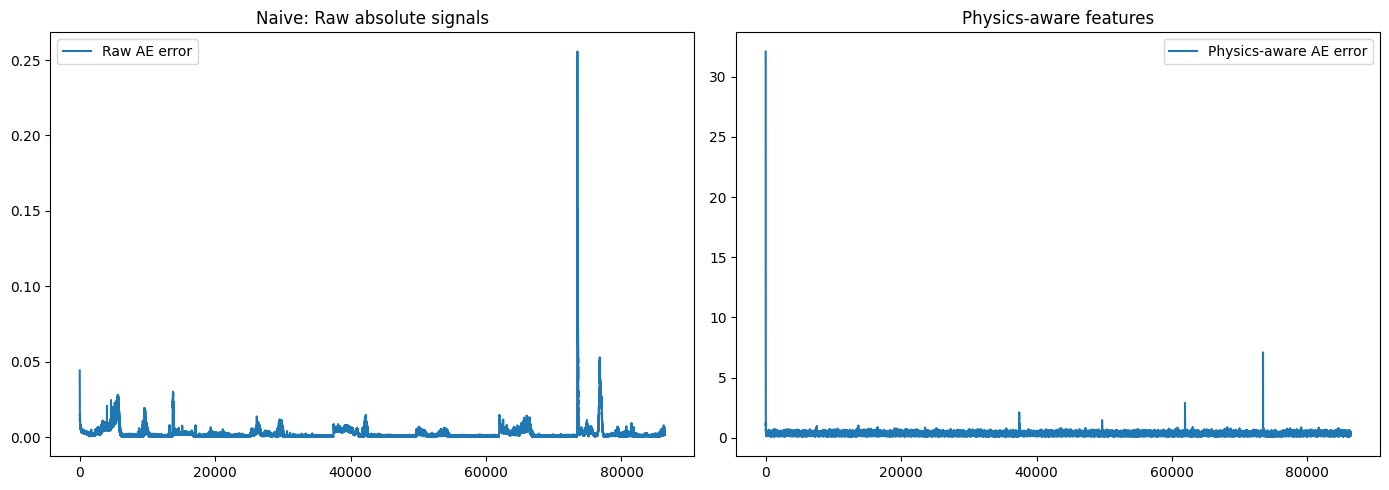

In [25]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(raw_ae_error, label="Raw AE error")
plt.title("Naive: Raw absolute signals")
plt.legend()

plt.subplot(1,2,2)
plt.plot(phys_ae_error, label="Physics-aware AE error")
plt.title("Physics-aware features")
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
print("Raw AE error stats:")
print(np.percentile(raw_ae_error, [90, 95, 99]))

print("\nPhysics-aware AE error stats:")
print(np.percentile(phys_ae_error, [90, 95, 99]))


Raw AE error stats:
[0.0048031  0.00685492 0.01928267]

Physics-aware AE error stats:
[0.42764025 0.4748088  0.5774243 ]


In [31]:
def train_autoencoder(X, epochs=30, batch_size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_tensor = torch.tensor(X, dtype=torch.float32)
    loader = DataLoader(
        TensorDataset(X_tensor),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=(device.type == "cuda")
    )

    model = AutoEncoder(X.shape[1], bottleneck=8).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for (batch,) in loader:
            batch = batch.to(device, non_blocking=True)
            opt.zero_grad()
            recon = model(batch)
            loss = loss_fn(recon, batch)
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        X_gpu = X_tensor.to(device)
        recon_full = model(X_gpu).cpu().numpy()
        recon_error = ((recon_full - X) ** 2).mean(axis=1)

    return recon_full, recon_error


In [49]:
raw_recon, raw_ae_error = train_autoencoder(X_raw_scaled[:10000])
phys_recon, phys_ae_error = train_autoencoder(X_phys_scaled[:10000])


In [50]:
sensor_col = "10-PI-1110"
sensor_idx = df_num.columns.get_loc(sensor_col)
time = df_num["Seconds"].values


In [51]:
raw_actual = df_num[sensor_col].values
phys_residual = df_num[sensor_col].values

raw_recon_unscaled = (
    raw_recon[:, sensor_idx] * scaler_raw.scale_[sensor_idx]
    + scaler_raw.mean_[sensor_idx]
)





In [52]:
phys_actual = raw_actual
phys_residual_idx = X_phys.columns.get_loc(sensor_col + "_res")

phys_recon_residual = phys_recon[:, phys_residual_idx]
phys_recon_unscaled = phys_residual + rolling_mean[sensor_col].values


ValueError: x and y must have same first dimension, but have shapes (86400,) and (10000,)

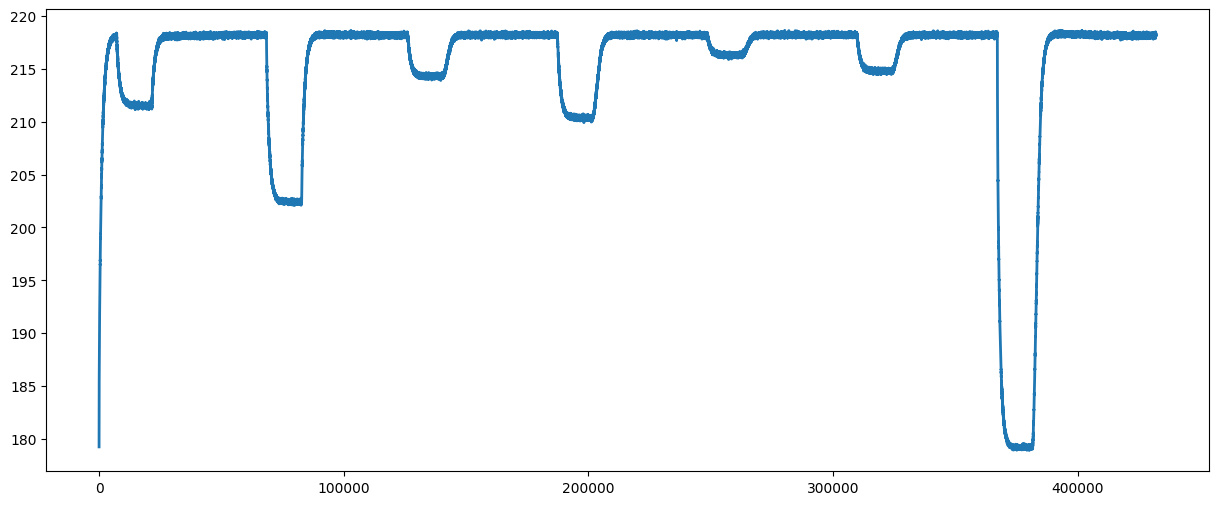

In [53]:
plt.figure(figsize=(15,6))

plt.plot(time, raw_actual, label="Actual sensor", linewidth=2)
plt.plot(time, raw_recon_unscaled, label="Raw AE reconstruction", alpha=0.7)
plt.plot(time, phys_recon_unscaled, label="Physics-aware AE reconstruction", alpha=0.7)

plt.xlabel("Time (seconds)")
plt.ylabel(sensor_col)
plt.title(f"Actual vs AE Reconstructions for {sensor_col}")
plt.legend()
plt.grid(True)

plt.show()
